# 로봇 인공지능 만들기 Assignment 5

기계항공공학부 2013-11815 이승섭

## Problem 1.
2차원 공간에 임의의 지형 지물이 주어졌을 때, 센서가 지형지물과의 거리만 또는 거리와 각도를 준다고 할 때, 로봇 위치를 추정하는 Particle Filter 프로그램을 작성하라.

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import norm

In [2]:
# Set up 2D space.
space_size = (20,20)
num_particles = 1000
sensor_range = 1.0
motion_noise = 0.5

# Set up obstacles.
obstacles = np.array([(3,3), (10,1), (12.5,13.6)]).astype(float)

# Initialize particles and weights.
particles = np.array(
    [np.random.uniform(0, space_size[0], num_particles),
     np.random.uniform(0, space_size[1], num_particles)]).T
weights = np.ones(num_particles) / num_particles


# Ground truth.
true_position = np.array([4,5]).astype(float)

In [3]:
# Define particle functions
def move_particles(particles, motion, noise=0.5):
    """ Move particles with added Gaussian noise. """
    particles += motion + np.random.normal(0, noise, particles.shape)
    particles = np.clip(particles, 0, space_size[0] - 1)  # Keep particles within bounds
    return particles

def measure_distances(particle, obstacles):
    """ Measure distances from a particle to all obstacles. """
    return np.array([np.linalg.norm(particle - obstacle) for obstacle in obstacles])

In [4]:
def update_weights(particles, weights, true_sensor_dists, obstacles, sensor_range):
    """ Update weights based on distance measurements to all obstacles. """
    for i, particle in enumerate(particles):
        # Get distances from this particle to all obstacles
        particle_dists = measure_distances(particle, obstacles)
        
        # Calculate likelihoods based on distances to each obstacle
        likelihoods = norm.pdf(true_sensor_dists, particle_dists, sensor_range)
        
        # Aggregate likelihoods to update the particle weight, e.g., by taking the product
        weights[i] = np.prod(likelihoods)
        
    weights += 1e-300  # Avoid zero weights
    weights /= np.sum(weights)  # Normalize
    return weights

In [5]:
def resample_particles(particles, weights):
    """ Resample particles based on their weights. """
    indices = np.random.choice(len(particles), size=len(particles), p=weights)
    return particles[indices]

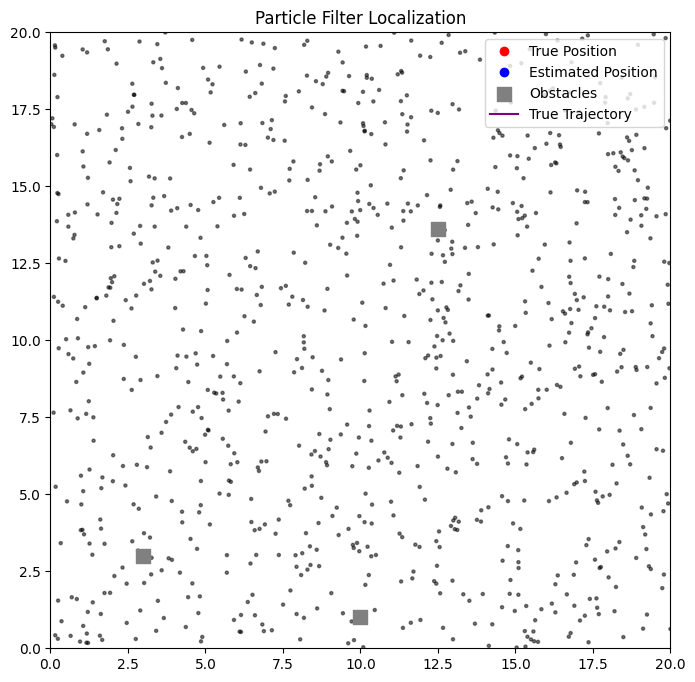

In [6]:
# Initialize plot
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot elements for particles, true position, and obstacles
particle_scatter = ax.scatter(particles[:, 0], particles[:, 1], color='k', s=weights * 5000, alpha=0.5)
true_position_plot, = ax.plot([], [], 'ro', label="True Position")
estimated_position_plot, = ax.plot([], [], 'bo', label="Estimated Position")
obstacle_plot = ax.scatter(*zip(*obstacles), color='grey', marker='s', s=100, label="Obstacles")
trajectory_line, = ax.plot([], [], 'purple', label="True Trajectory")

# Set plot limits and labels
ax.set_xlim(0, space_size[0])
ax.set_ylim(0, space_size[1])
ax.legend(loc="upper right")
ax.set_title("Particle Filter Localization")

# Animation update function
def update(frame):
    global particles, weights, true_position, trajectory
    
    # Move the robot and particles
    motion = np.array([np.random.uniform(-1, 1), np.random.uniform(-1, 1)])  # Random motion
    true_position = move_particles(true_position[np.newaxis, :], motion, noise=0)[0]
    trajectory.append(true_position)
    particles = move_particles(particles, motion, motion_noise)

    # Simulate sensor reading from the robot's true position to each obstacle
    true_sensor_dists = measure_distances(true_position, obstacles)

    # Update particle weights based on sensor reading
    weights = update_weights(particles, weights, true_sensor_dists, obstacles, sensor_range)

    # Resample particles based on updated weights
    particles = resample_particles(particles, weights)

    # Estimate position as the weighted mean of particles
    estimate = np.average(particles, weights=weights, axis=0)

    # Update particle scatter plot
    particle_scatter.set_offsets(particles)
    particle_sizes = weights * 5000
    particle_scatter.set_sizes(particle_sizes)
    
    # Update true position and estimated position
    true_position_plot.set_data(*true_position)
    estimated_position_plot.set_data(*estimate)
    
    # Update trajectory line
    trajectory_line.set_data(*zip(*trajectory))

# Create the animation
ani = FuncAnimation(fig, update, frames=20, interval=500, repeat=False)

plt.show()